# Berry Production Prediction

- [Data Cleaning](#Data-Cleaning)
- [Models](#Models)
- [Dashboard](#Dashboard)
- [Appendix](#Appendix)

In [1]:
! python3 -m pip install --quiet fbprophet

In [2]:
import numpy as np
import pandas as pd
from fbprophet import Prophet
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm
import statsmodels.api as sm
import itertools
from IPython.core.display import HTML
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# Data Cleaning

In [3]:
df = pd.read_excel('sample.xlsx', header = None, names = ['y'])
df.head()

,y
0,0.008826
1,0.014048
2,0.027507
3,0.076269
4,0.116793


In [4]:
df.shape

(235, 1)

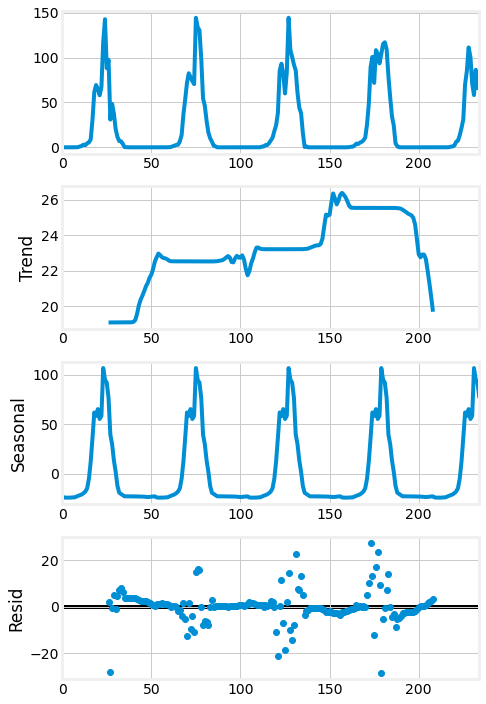

In [5]:
plt.rcParams['figure.figsize'] = 7, 10
decomposition = seasonal_decompose(df, period = 52)
fig = decomposition.plot()
pass

Based on the above plot, it's quite explicit that there is a consistent seasonal pattern on berry production. Treating the first week as the beginning of the cycle and $52$ weeks as the cycle length, berry production is low around the start and the end of the cycle, and grows substantially at the middle of the cycle. Besides, according to the fourth chart which exhibits the residual situation, the production of berry is unstable.

# Models

Based on my understanding, there are three major types of times series models. The first one is the typical machine learning models for times series problem, such as AR, MA, ARIMA and SARIMA. The second type is the deep learning methods including RNN, LSTM etc. However, due to the limited data volumn under this condition, deep learning method is not the appropriate choice. The latest technology is Prophet, which is an open source software released by Facebook’s Core Data Science team. It is a procedure for forecasting time series data based on Generalized Additive Model and is effective for time series with strong seasonal effects.

Because of the apparent seasonality in the berry production dataset, I decide to apply SARIMA and Prophet approaches to make predictions. Spliting the last 10 weeks as a validation set, these two approaches are compared and selected.

In [6]:
train = df.iloc[:-10, :]
validation = df.iloc[-10:, :]

## SARIMA

### Parameter Tuning

In this part, my goal is to choose the appropriate (p,d,q) order and (P,D,Q,s) order of the seasonal component of the SARIMA model. The parameter tuning strategy is grid search and the evaluation of model performance is model AIC.

In [7]:
best_aic = np.infty
rg = range(0, 2)
group = list(itertools.product(rg, rg, rg))
seasonal_group = [(i[0], i[1], i[2], 52) for i in group]

with tqdm(total = 64) as p:
    for i in group:
        for j in seasonal_group:
            model = sm.tsa.statespace.SARIMAX(train, order = i, seasonal_order = j).fit()
            aic_ = model.aic
            if aic_ < best_aic:
                best_aic = aic_
                best_order = [i, j]
                best_model = model
            p.update(1)

100%|██████████| 64/64 [04:17<00:00,  4.03s/it]


### Prediction Result for Validation Set

In [8]:
yhat_val_sarima = best_model.get_prediction(start = 0, end = train.shape[0] + 10 - 1).predicted_mean.values
yhat_val_sarima[yhat_val_sarima < 0] = 0
# validation MSE
mse_val_sarima = np.sum((yhat_val_sarima[-10:] - df['y'][-10:]) ** 2)

## Bayesian model Prediction with `prophet`

The `prophet` package in Python requires a column to represent date. However, since the berry production dataset doesn't provide this information, a date variable needs to be simulated.

In [9]:
# simulate date variable
ds = [datetime.datetime.strptime('2016-7-25', "%Y-%m-%d")]
for i in range(train.shape[0] - 1):
    ds += [ds[-1] + datetime.timedelta(days = 7)]
train['ds'] = ds

In [10]:
model = Prophet(weekly_seasonality = False, daily_seasonality = False, holidays_prior_scale = 0)
model = model.fit(train)
future = model.make_future_dataframe(periods = 10, freq = 'W')
forecast = model.predict(future)
yhat_val_prophet = forecast['yhat'].copy()
yhat_val_prophet[yhat_val_prophet < 0] = 0
# validation MSE
mse_val_prophet = np.sum((yhat_val_prophet[-10:] - df['y'][-10:]) ** 2)

## Final Model

In [11]:
print('The MSE of validation set based on SARIMA:', mse_val_sarima)
print('The MSE of validation set based on Prophet:', mse_val_prophet)

The MSE of validation set based on SARIMA: 9629.896252868748
The MSE of validation set based on Prophet: 9756.05993702983


Since the MSE of SARIMA is lower than that of Prophet, SARIMA seems to have better performance in berry production prediction. Therefore, SARIMA will be the final model applied in this project. The following process is to use the best parameter tuned before to train a new SARIMA model based on the whole dataset.

In [12]:
# Final Model
model = sm.tsa.statespace.SARIMAX(df, order = best_order[0], seasonal_order = best_order[1]).fit().\
get_prediction(start = 0, end = df.shape[0] + 10 - 1)
yhat = model.predicted_mean.values
CI = model.conf_int()
yhat[yhat < 0] = 0

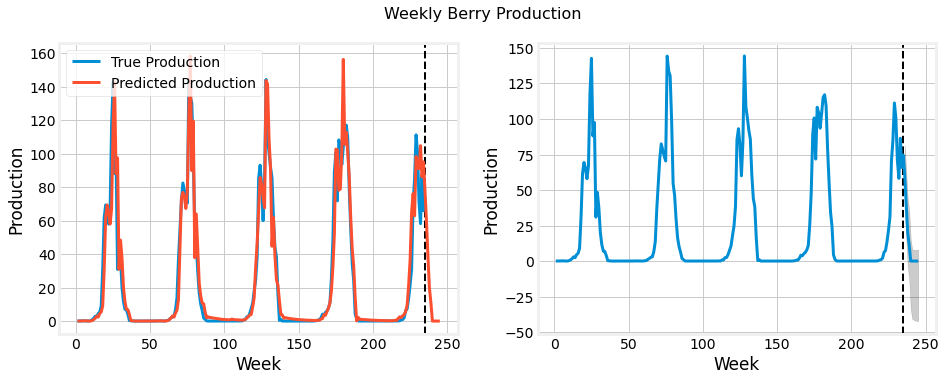

In [13]:
# Plot
y = df['y']
y_adj = pd.concat([df['y'], pd.Series(yhat[-10:])], ignore_index = True)

fig, axs = plt.subplots(1, 2, figsize = (14, 5))
fig.suptitle('Weekly Berry Production', fontsize = 16)
axs = axs.ravel()
for i in range(2):
    axs[i].axvline(len(y), linestyle = 'dashed', color = 'black', linewidth = 2)
    axs[i].set_xlabel('Week')
    axs[i].set_ylabel('Production')
axs[0].plot(list(range(1, len(y) + 1)), y, '-', linewidth = 3, label = 'True Production')
axs[0].plot(list(range(1, len(yhat) + 1)), yhat, '-', linewidth = 3, label = 'Predicted Production')
axs[0].legend()
axs[1].plot(list(range(1, len(y_adj) + 1)), y_adj, '-', linewidth = 3)
axs[1].fill_between(range(len(y) + 1, len(y) + 11), CI['lower y'][-10:], CI['upper y'][-10:], 
                    color = 'k', alpha = 0.2)
pass

In [14]:
# store prediction results into df_pred dataset
df_pred = pd.DataFrame(yhat[-10:], columns = ['Predicted Production']).reset_index().rename({'index': 'Week No.'}, 
                                                                                          axis = 1)
df_pred['Week No.'] = df_pred['Week No.'] + df.shape[0] + 1
print(df_pred.to_string(index = False))
print('Week No. starts from 1')

 Week No.  Predicted Production
      236             59.878730
      237             38.556469
      238             19.721005
      239             11.007910
      240              0.000000
      241              0.000000
      242              0.000000
      243              0.000000
      244              0.000000
      245              0.000000
Week No. starts from 1


# Dashboard

In this section, I construct a simple dashboard to summarize the conclusion through visualization. To protect data privacy, the original dataset is not published and the dashboard URL is not shared in any place except this Jupyter notebook.

In [15]:
# Include the result of Prophet and SARIMA in the dashboard
ds = [datetime.datetime.strptime('2016-7-25', "%Y-%m-%d")]
for i in range(df.shape[0] - 1):
    ds += [ds[-1] + datetime.timedelta(days = 7)]
df['ds'] = ds

model = Prophet(weekly_seasonality = False, daily_seasonality = False, holidays_prior_scale = 0)
model = model.fit(df)
future = model.make_future_dataframe(periods = 10, freq = 'W')
forecast = model.predict(future)
yhat_prophet = forecast['yhat'].copy()
yhat_prophet[yhat_prophet < 0] = 0

df_new = np.zeros((len(yhat), 2))
df_new[:, 0] = yhat
df_new[:, 1] = yhat_prophet
pd.DataFrame(df_new, columns = ['yhat', 'yhat_p']).to_csv('yhat.csv', index = False)

In [16]:
# Can also be viewed at
HTML('''<iframe width="900" height="500" frameborder="0" scrolling="no" src="https://berry-production.herokuapp.com/"></iframe>''')


The detailed dashboard coding is shown in the [Appendix](#Appendix) section.

# Appendix

```python
# streamlit run app.py
import streamlit as st
import numpy as np
import pandas as pd
import altair as alt
from PIL import Image

session = st.sidebar.selectbox("Section", ["Introduction", "Data Analysis", "Prediction"])
st.title('Berry Production')
df = pd.read_excel('sample.xlsx', header = None, names = ['y'])
df['Week'] = list(range(1, df.shape[0] + 1))
yhats = pd.read_csv('yhat.csv')

if session == "Introduction":
    st.sidebar.subheader("Dashboard Introduction")

    # image
    image = Image.open('berry_img.jpg')
    st.image(image, width = 700)
    st.subheader("Introduction")
    st.write("""
    This is a dashboard aiming to analyze the berry production dataset recorded on a weekly basis.
    The major goal of this project is to predict the berry productions in the next 10 weeks.
    The original dataset only contains the production information, and no other information like the dates of records is provided.
    Being a typical time series problem with apparent seasonal trend, Seasonal Autoregressive Integrated Moving Average (SARIMA) and Facebook Prophet are applied to get the prediction results.
    After the model selection process based on the MSE in the validation set, SARIMA is decided as the final model.
    But the prediction results of both models will be exhibited in this dashboard.
    
    This dashboard includes the following three parts:
    - Introduction
    - Data Analysis
    - Prediction

    The **Data Analysis** section uses the original data to create visualizations and conduct analysis, while the predicted values are incorporated for analysis in the **Prediction** part.""")

if session == "Data Analysis":
    # sidebar
    st.sidebar.subheader("Data Analysis")
    parts = st.sidebar.radio("Two Parts:", ["Overview", "Periodic Data"])
    
    if parts == "Overview":
        # sidebar
        st.sidebar.subheader("Overview")
        week_range =  st.sidebar.slider('Range of week:', 1, max(df['Week']), (1, max(df['Week'])))

        # Reference: https://altair-viz.github.io/gallery/multiline_tooltip.html
        # Create a selection that chooses the nearest point & selects based on x-value
        source = df[df['Week'].isin(list(range(week_range[0], week_range[1] + 1)))]
        source['Category'] = 'True Production'
        source['Production'] = np.round(source['y'], 3)
        # Create a selection that chooses the nearest point & selects based on x-value
        nearest = alt.selection(type = 'single', nearest = True, on = 'mouseover',
                                fields = ['Week'], empty = 'none')

        # The basic line
        line = alt.Chart(source).mark_line(interpolate = 'basis').encode(
            x='Week:Q',
            y='Production:Q',
            color='Category:N'
        )

        # Transparent selectors across the chart. This is what tells us
        # the x-value of the cursor
        selectors = alt.Chart(source).mark_point().encode(
            x='Week:Q',
            opacity=alt.value(0),
        ).add_selection(
            nearest
        )

        # Draw points on the line, and highlight based on selection
        points = line.mark_point().encode(
            opacity=alt.condition(nearest, alt.value(1), alt.value(0))
        )

        # Draw text labels near the points, and highlight based on selection
        text = line.mark_text(align='left', dx=5, dy=-5).encode(
            text=alt.condition(nearest, 'Production:Q', alt.value(' '))
        )

        # Draw a rule at the location of the selection
        rules = alt.Chart(source).mark_rule(color='gray').encode(
            x='Week:Q',
        ).transform_filter(
            nearest
        )

        # Put the five layers into a chart and bind the data
        fig1 = alt.layer(
            line, selectors, points, rules, text
        ).properties(
            width=600, height=300
        )

        # show figure
        ex = st.checkbox('See Explanation')
        if ex:
            st.write("""This is the visualization of the original weekly dataset, which describes the general trend of berry production.
            By adjusting the slider, users can select a specific time range to study the berry production fluctuation within that period.
            Based on the figure, there is a consistent seasonal pattern on berry production.""")
        st.subheader('Weekly Berry Production')
        st.altair_chart(fig1, use_container_width=True)
            
    if parts == "Periodic Data":
        st.sidebar.subheader("Periodic Data")
        week_start = st.sidebar.number_input("Starting Week (up to 52):", 1, 52, 1)

        # data
        source = df[df['Week'] >= week_start]
        source['Week'] = source['Week'] - week_start + 1
        source_s = pd.Series(np.concatenate((np.repeat('1st Year', 52), 
        np.repeat('2nd Year', 52), np.repeat('3rd Year', 52), np.repeat('4th Year', 52), 
        np.repeat('5th Year', df.shape[0] - 52*4))), name = 'Time')
        source.reset_index(drop = True, inplace = True)
        source = pd.concat([source, source_s[:source.shape[0]]], axis = 1)
        source['Position Within the Cycle'] = (source['Week'] - 1) % 52 + 1

        years = st.sidebar.multiselect("Included Years:", list(source['Time'].unique()), default = list(source['Time'].unique()))
        # figure
        source = source[source['Time'].isin(years)]
        fig4 = alt.Chart().mark_line(point = True).encode(
            alt.X('Position Within the Cycle'),
            alt.Y('y', title = 'Production'),
            #alt.Facet('Time', columns=1),
            )
        fig4 = alt.layer(fig4, data=source).facet(
            row = 'Time'
        )

        # show figure
        ex = st.checkbox('See Explanation')
        if ex:
            st.write("""This figure breaks the original dataset into separate year by approximating one year as 52 weeks.
            The sidebars allow the users to determine the starting week and included years.
            The berry production data before the starting week and outside of the included years will not show in the figure.
            By reading this chart, the weekly data at the same position in each cycle can be easily compared.
            For example, we can see that the cycle peak is moving across time.""")
        st.subheader('Weekly Berry Production in Each Year')
        st.altair_chart(fig4, use_container_width=True)

if session == "Prediction":
    model = st.sidebar.selectbox("Predictive Model", ["SARIMA", "Prophet"])
    if model == "SARIMA":
        yhat = yhats['yhat']
    else:
        yhat = yhats['yhat_p']
    yhat = pd.Series(np.array(yhat), name = 'yhat')
    # data
    st.sidebar.subheader("Prediction")
    df['Predicted Production'] = yhat[:-10]
    source = df.rename({'y': 'True Production'}, axis = 1).melt('Week', var_name = 'Category', value_name = 'Production')
    df_pred = pd.DataFrame(yhat[-10:]).reset_index().rename({'index': 'Week', 'yhat': 'Production'}, axis = 1)
    df_pred['Week'] = df_pred['Week'] + 1
    source = pd.concat([source, df_pred.assign(Category = 'Predicted Production')], axis = 0)
    parts = st.sidebar.radio("Three Parts:", ["Prediction Result", "Prediction Comparison", "Periodic Data"])
    if parts == 'Prediction Result':
        # sidebar
        st.sidebar.subheader("Prediction Result")
        week_range =  st.sidebar.slider('Range of week:', 1, max(source['Week']), (1, max(source['Week'])))
        plots = st.sidebar.multiselect("Show Chart:", ['True Production', 'Predicted Production'], default = ['True Production', 'Predicted Production'])
        
        # plot
        source = source[source['Week'].isin(list(range(week_range[0], week_range[1] + 1)))]
        source = source[source['Category'].isin(plots)]
        source = np.round(source, 3)
        # Create a selection that chooses the nearest point & selects based on x-value
        nearest = alt.selection(type='single', nearest=True, on='mouseover',
                                fields=['Week'], empty='none')

        # The basic line
        line = alt.Chart(source).mark_line(interpolate='basis').encode(
            x='Week:Q',
            y='Production:Q',
            color='Category:N'
        )

        # Transparent selectors across the chart. This is what tells us
        # the x-value of the cursor
        selectors = alt.Chart(source).mark_point().encode(
            x='Week:Q',
            opacity=alt.value(0),
        ).add_selection(
            nearest
        )

        # Draw points on the line, and highlight based on selection
        points = line.mark_point().encode(
            opacity=alt.condition(nearest, alt.value(1), alt.value(0))
        )

        # Draw text labels near the points, and highlight based on selection
        text = line.mark_text(align='left', dx=5, dy=-5).encode(
            text=alt.condition(nearest, 'Production:Q', alt.value(' '))
        )

        # Draw a rule at the location of the selection
        rules = alt.Chart(source).mark_rule(color='gray').encode(
            x='Week:Q',
        ).transform_filter(
            nearest
        )

        # Add vertical line
        if week_range[1] >= df.shape[0]:  
            overlay = pd.DataFrame({'x': [df.shape[0]]})
            vline = alt.Chart(overlay).mark_rule(color='black', strokeWidth=2, strokeDash=[3,5]).encode(x='x:Q')
            # Put the five layers into a chart and bind the data
            fig2 = alt.layer(
                line, selectors, points, rules, text, vline
            ).properties(
                width=600, height=300
            )
        else:
            # Put the five layers into a chart and bind the data
            fig2 = alt.layer(
                line, selectors, points, rules, text
            ).properties(
                width=600, height=300
            )

        # show figure
        ex = st.checkbox('See Explanation')
        if ex:
            st.write("""The model selection procedure can be accessed at the Jupyter notebook.
            The model applied currently in this section is {}.
            Parameter tuning has been conducted for the final model. The goal is to predict the berry production in the next 10 weeks.
            The exact predicted data is shown in the table at bottom, where the week IDs are represented by their index in the original dataset starting from 1.""".format(model))
        st.subheader('Predicted and True Berry Production on a Weekly Basis')
        st.altair_chart(fig2, use_container_width=True)
        check = st.checkbox('Show the Next 10 Weeks of Productions Using {}'.format(model), value = False)
        if check:
            st.write(df_pred.rename({'Production': 'Predicted Production'}, axis = 1))
    
    if parts == 'Prediction Comparison':
        st.sidebar.subheader("Prediction Comparison")
        weeks = st.sidebar.multiselect('Predicted Weeks:', list(df_pred['Week']), default = [236, 237])

        # data
        ddf = np.zeros((df_pred.shape[0], 4))
        for i in range(df_pred.shape[0]):
            for j in range(4):
                ddf[i, j] = df[df['Week'] == 236 + i - 52 * (4 - j)]['y']
        data = pd.concat([df_pred, pd.DataFrame(ddf, columns = ['1st Year', '2nd Year', '3rd Year', '4th Year'])], axis = 1).rename({'Production': '5th Year'}, axis = 1)
        data = data.melt('Week', var_name = 'Time', value_name = 'Production')
        data = data[data['Week'].isin(weeks)]

        fig3 = alt.Chart(data).mark_bar(size = 20).encode(
            x='Week:N',
            y='Production:Q',
            color='Week:N',
            column='Time:N'
        )

        # figure
        ex = st.checkbox('See Explanation')
        if ex:
            st.write("""In this section, the goal is to compare the predicted berry production values in the next 10 weeks with their counterparts in the previous years.
            The week IDs starts from 236 and ends with 245. The approximate trend of production can be obtained through this figure.""")
        st.subheader('Berry Production Comparison for Each Year')
        st.write(fig3)
        check = st.checkbox('Show the Next 10 Weeks of Productions Using {}'.format(model), value = False)
        if check:
            st.write(df_pred.rename({'Production': 'Predicted Production'}, axis = 1))

    if parts == "Periodic Data":
        st.sidebar.subheader("Periodic Data")
        week_start = st.sidebar.number_input("Starting Week (up to 52):", 1, 52, 1)

        # data
        source = df[df['Week'] >= week_start]
        source = pd.concat([source, df_pred.rename({'Production': 'y'}, axis = 1)], axis = 0)
        source['Week'] = source['Week'] - week_start + 1
        source_s = pd.Series(np.concatenate((np.repeat('1st Year', 52), 
        np.repeat('2nd Year', 52), np.repeat('3rd Year', 52), np.repeat('4th Year', 52), 
        np.repeat('5th Year', df.shape[0] - 52*4 + 10))), name = 'Time')
        source.reset_index(drop = True, inplace = True)
        source = pd.concat([source, source_s[:source.shape[0]]], axis = 1)
        source['Position Within the Cycle'] = (source['Week'] - 1) % 52 + 1

        years = st.sidebar.multiselect("Included Years:", list(source['Time'].unique()), default = list(source['Time'].unique()))
        # figure
        source = source[source['Time'].isin(years)]
        fig5 = alt.Chart().mark_line(point = True).encode(
            alt.X('Position Within the Cycle'),
            alt.Y('y', title = 'Production'),
            )
        overlay = pd.DataFrame({'x': [source.iloc[-11, :]['Position Within the Cycle']]})
        vline = alt.Chart(overlay).mark_rule(color='black', strokeWidth=2, strokeDash=[3,5]).encode(x='x:Q')

        fig5 = alt.layer(fig5, vline, data=source).facet(
            row = 'Time'
        )

        # show figure
        ex = st.checkbox('See Explanation')
        if ex:
            st.write("""The objective for this figure is to detect whether the production trend in the last year accords with the corresponding trends in the previous years.
            The black dotted vertical lines in each figure denote the counterpart of the starting week of prediction.
            Similar to the Data Analysis section, starting week and included years can be adjusted using the sidebars.""")
        st.subheader('Weekly Berry Production in Each Year Including the Predicted Values')
        st.altair_chart(fig5, use_container_width = True)
        check = st.checkbox('Show the Next 10 Weeks of Productions Using {}'.format(model), value = False)
        if check:
            st.write(df_pred.rename({'Production': 'Predicted Production'}, axis = 1))
```